# Performance Estimation for NNs

First, loading all modules and code:

In [1]:
import numpy as np
from Class import *
from ChipCal import *
from Device import *
# import xlrd
import matplotlib.pyplot as plt
import matplotlib
from data_process import *
import os
import itertools
from pathlib import Path

In [2]:
doryta_base = Path(os.path.abspath("../../../.."))

if not os.path.isdir(doryta_base / "figures"):
    os.mkdir(doryta_base / "figures")

Defining data to load and procedure to do so

In [3]:
workload_name = ['small_lenet','small_lenet_fashion','large_lenet','large_lenet_fashion']
data_name = [doryta_base / "data" / "experiments" / "performance_estimation" / f"{name}-average.csv"
             for name in workload_name]

def load_csv_data(path):
    dtype_data = {
        'names': ("name-unit", "out-synapses", "leak", "integration", "fire"),
        'formats': (str, 'f8', 'f8', 'f8', 'f8')}
    csv_data = np.loadtxt(path, delimiter=",", skiprows=2, dtype=dtype_data)
    return np.array([csv_data['integration'], csv_data['fire']]).T

In [ ]:
# workload_name = ['small_lenet','small_lenet_fashion','large_lenet','large_lenet_fashion']
# data_name = ['small_lenet.xls','small_lenet_fashion.xls','large_lenet.xls','large_lenet_fashion.xls']
# 
# def Data_read(name):
#     # read all the fire and integration data 
#     lenet = []
#     data = xlrd.open_workbook(name)
#     table = data.sheet_by_index(0)
#     for i in range(table.nrows):
#         line = table.row_values(i)
#         lenet.append(line)
#     lenet = np.array(lenet)
#     return lenet

## Estimating performance

Processing data (estimating performance) for each workload and technology at the time

In [4]:
# parameters we have to offer
# work_load and its data selection
# dictionary keyword:  neuron_name, all/layer, workload, data type, wire width
data_dict = defaultdict(lambda: defaultdict(lambda: defaultdict( lambda: defaultdict(lambda: defaultdict(lambda: [])))))
devices = [('Mn3Sn', 'Spin'), ('NiO', 'Spin'), ('digit', 'CMOS'), ('Analog', 'CMOS')]
pitch_plot = np.array([10, 15, 20, 25, 30])
for device_name, device in devices:
    pitch_store = np.array([10e-9, 15e-9, 20e-9, 25e-9, 30e-9])
    Result = []
    for pitch in pitch_store:
        Result_temp = []
        for workload, workload_data_name in zip(workload_name, data_name):
            # Lenet_data = Data_read(workload_data_name)
            Lenet_data = load_csv_data(workload_data_name)

            # pitch information
            Consts = Param(pitch=pitch, resis_cal=resistivity_cal, cap_cal=Cap, liner=3e-9)
            Consts = network_param(Consts, workload, Lenet_data)
            if device == 'Spin':
                t_pulse = 5e-12
                if device_name == 'Mn3Sn':
                    J_density = 3e10
                elif device_name == 'NiO':
                    J_density = 3e11
                Neu = Dev()
                Syn = Dev()
                Neu = neuron_cal(Consts, Neu, t_pulse, J_density, device_name)
                Syn, Consts = synapse_cal(Consts, Syn, Neu.Idev, t_pulse)
                Neu.Idev = 5.5e-4
            elif device == 'CMOS':
                Neu = Dev()
                Syn = Dev()
                Neu, Syn = CMOS_cal(Neu, Syn, device_name)
                Consts.Vdd = Neu.Vdev
            Arch = arch_level(Neu, Syn)
            Arch = Chip_performance(Arch, Consts)
            Result_temp.append(Arch)
        Result.append(Result_temp)
    output_name_all = ['ACP', 'ECP', 'TCP', 'Asyn', 'Esyn', 'Tsyn',
                       'Aneu', 'Eneu', 'Tneu', 'Eicloc', 'Ticloc', 'Eicglo', 'Ticglo']
    for name in output_name_all:
        data1 = Data_Extract(Result, name, False)
        locals()[device_name+name+'_all'] = data1
        data2 = Data_Extract(Result, name, True)
        locals()[device_name+name+'_layered'] = data2
        for index1, load_name in enumerate(workload_name):
            for index2, pitch_quantity in enumerate(pitch_plot):
                data_dict[device_name]['all'][load_name][name][pitch_quantity] = data1[index2][index1]
                data_dict[device_name]['layer'][load_name][name][pitch_quantity] = data2[index2][index1]

## Generating Figure 9

In [5]:
pitch_plot = np.array([10, 15, 20, 25, 30])

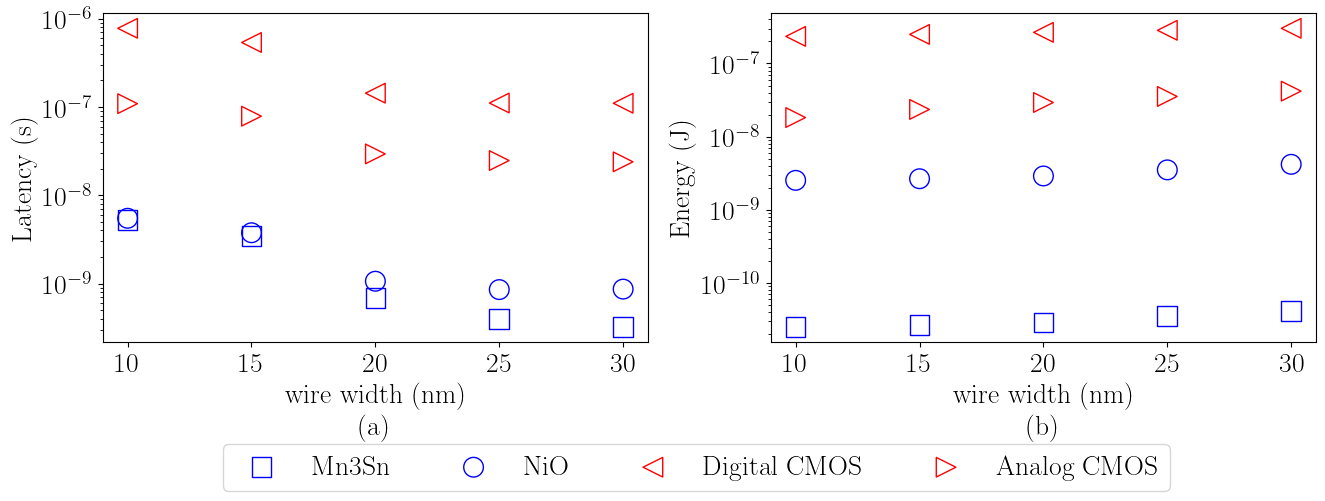

In [6]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 20
})

def perf_from(device, parameter):
    return list(data_dict[device]['all']['small_lenet'][parameter].values())

fig = plt.figure(figsize=(14, 5))
axes = fig.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=2.3)
axes[0].scatter(pitch_plot, perf_from('Mn3Sn', 'TCP'), marker='s', c='none', edgecolors='blue', s=200)
axes[0].scatter(pitch_plot, perf_from('NiO', 'TCP'), marker='o', c='none', edgecolors='blue', s=200)
axes[0].scatter(pitch_plot, perf_from('digit', 'TCP'), marker='<', c='none', edgecolors='red', s=200)
axes[0].scatter(pitch_plot, perf_from('Analog', 'TCP'), marker='>', c='none', edgecolors='red', s=200)
axes[0].set_yscale('log')
axes[0].set_xlabel('wire width (nm) \n (a)')
axes[0].set_ylabel('Latency (s)')
#axes[0].tick_params(labelsize=14)
#plt.title('Small Lenet',fontsize = 16)

axes[1].scatter(pitch_plot, perf_from('Mn3Sn', 'ECP'), marker='s', c='none', edgecolors='blue', s=200)
axes[1].scatter(pitch_plot, perf_from('NiO', 'ECP'), marker='o', c='none', edgecolors='blue', s=200)
axes[1].scatter(pitch_plot, perf_from('digit', 'ECP'), marker='<', c='none', edgecolors='red', s=200)
axes[1].scatter(pitch_plot, perf_from('Analog', 'ECP'), marker='>', c='none', edgecolors='red', s=200)
axes[1].set_yscale('log')
axes[1].set_xlabel('wire width (nm) \n (b)')
axes[1].set_ylabel('Energy (J)')
#axes[1].tick_params(labelsize = 14)
#plt.title('Small Lenet',fontsize = 16)
fig.legend(['Mn3Sn', 'NiO', 'Digital CMOS', 'Analog CMOS'], ncol = 4, loc = 8, bbox_to_anchor = (0.5,-0.13), markerscale = 1)
#plt.savefig(doryta_base / "figures" / 'interconnect_effect.svg', dpi = 600,bbox_inches = 'tight')
plt.savefig(doryta_base / "figures" / 'interconnect_effect.pdf', dpi = 600, bbox_inches = 'tight')
plt.savefig(doryta_base / "figures" / 'interconnect_effect.pgf', dpi = 600, bbox_inches = 'tight')
#plt.savefig(doryta_base / "figures" / 'interconnect_effect.png', dpi = 600,bbox_inches = 'tight')

#matplotlib.use(mtp_backend)
#matplotlib.rcParams = mtp_params
plt.show()

## Generating Figure 10

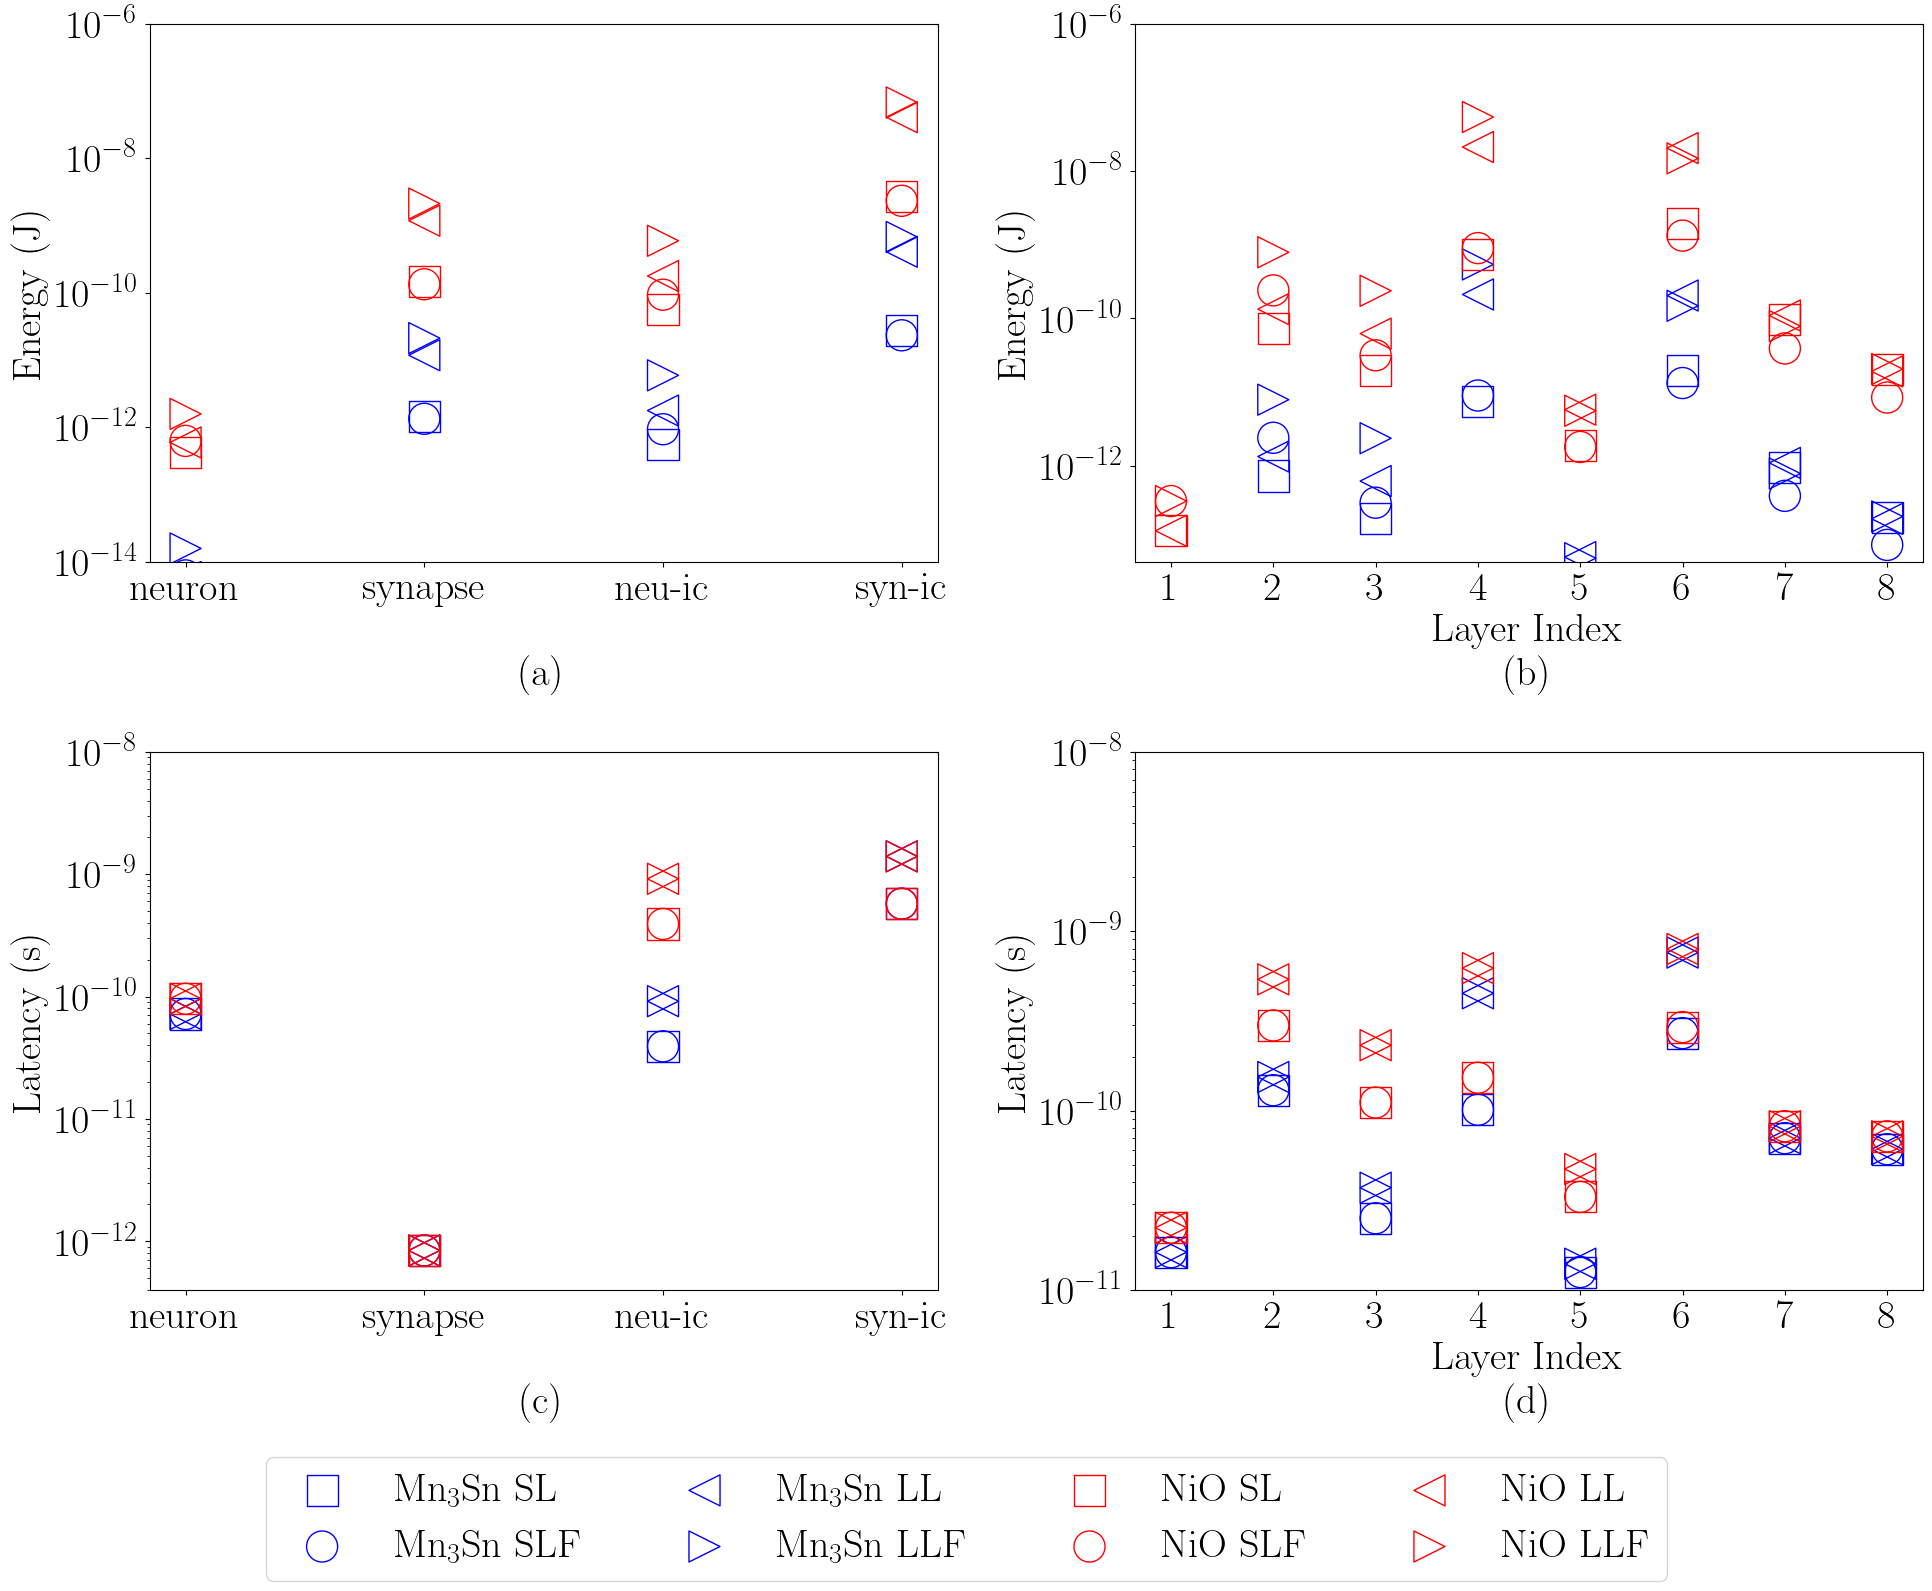

In [7]:
matplotlib.rcParams.update({'font.size': 29})

# different color for different neurons
color = ['blue', 'red', 'black', 'violet']
marker = ['s', 'o', '<', '>']  # different marker for different workload
fig = plt.figure(figsize=(20, 15))
axes = fig.subplots(nrows=2, ncols=2)
# figure 1 Energy device
Energy_device = np.array([[Mn3SnEneu_all[2, :], NiOEneu_all[2, :]], [Mn3SnEsyn_all[2, :], NiOEsyn_all[2, :]], [
                         Mn3SnEicglo_all[2, :], NiOEicglo_all[2, :]], [Mn3SnEicloc_all[2, :], NiOEicloc_all[2, :]]])
for i in range(2):
    for j in range(4):
        axes[0, 0].scatter(np.arange(1, 5, 1), Energy_device[:, i, j], marker=marker[j], c='none', edgecolors=color[i], s=500)
axes[0, 0].set_xlabel('\n (a)')
axes[0, 0].set_ylabel('Energy (J)')
axes[0, 0].xaxis.set_ticks([1, 2, 3, 4])
axes[0, 0].set_xticklabels(['neuron', 'synapse', 'neu-ic', 'syn-ic'])
#axes[0, 0].tick_params(labelsize=22)
axes[0, 0].set_ylim(1e-14, 1e-6)
axes[0, 0].set_yscale('log')

Energy_layer = np.array([Mn3SnECP_layered[2], NiOECP_layered[2]])
for i in range(2):
    for j in range(4):
        axes[0, 1].scatter(np.arange(1, 9, 1), Energy_layer[i, j, :], marker=marker[j], c='none', edgecolors=color[i], s=500)
axes[0, 1].set_xlabel('Layer Index \n (b)')
axes[0, 1].set_ylabel('Energy (J)')
axes[0, 1].xaxis.set_ticks(np.arange(1, 9))
#axes[0, 1].tick_params(labelsize=22)
axes[0, 1].set_ylim(0.5e-13, 1e-6)
axes[0, 1].set_yscale('log')


Latency_device = np.array([[Mn3SnTneu_all[2, :], NiOTneu_all[2, :]], [Mn3SnTsyn_all[2, :], NiOTsyn_all[2, :]], [
                          Mn3SnTicglo_all[2, :], NiOTicglo_all[2, :]], [Mn3SnTicloc_all[2, :], NiOTicloc_all[2, :]]])
for i in range(2):
    for j in range(4):
        axes[1, 0].scatter(np.arange(1, 5, 1), Latency_device[:, i, j], marker=marker[j], c='none', edgecolors=color[i], s=500)
axes[1, 0].set_xlabel('\n (c)')
axes[1, 0].set_ylabel('Latency (s)')
axes[1, 0].xaxis.set_ticks([1, 2, 3, 4])
axes[1, 0].set_xticklabels(['neuron', 'synapse', 'neu-ic', 'syn-ic'])
#axes[1, 0].tick_params(labelsize=22)
axes[1, 0].set_ylim(4e-13, 1e-8)
axes[1, 0].set_yscale('log')

Latency_layer = np.array([Mn3SnTCP_layered[2], NiOTCP_layered[2]])
for i in range(2):
    for j in range(4):
        axes[1, 1].scatter(np.arange(1, 9, 1), Latency_layer[i, j, :], marker=marker[j], c='none', edgecolors=color[i], s=500)
axes[1, 1].set_xlabel('Layer Index \n (d)')
axes[1, 1].set_ylabel('Latency (s)')
axes[1, 1].xaxis.set_ticks(np.arange(1, 9))
#axes[1, 1].tick_params(labelsize=22)
axes[1, 1].set_ylim(1e-11, 1e-8)
axes[1, 1].set_yscale('log')

fig.legend([r'Mn$_3$Sn SL', r'Mn$_3$Sn SLF', r'Mn$_3$Sn LL', r'Mn$_3$Sn LLF', r'NiO SL', r'NiO SLF',
           r'NiO LL', r'NiO LLF'], ncol=4, loc=8, bbox_to_anchor=(0.5, -0.09), markerscale=1)
# plt.subplots_adjust(bottom=0)
plt.tight_layout()
# plt.savefig('combine.eps',dpi = 600,format = 'eps',bbox_inches = 'tight')
#plt.savefig(doryta_base / "figures" / 'comparison.svg',dpi = 600,bbox_inches = 'tight')
plt.savefig(doryta_base / "figures" / 'comparison.pdf', dpi=600, bbox_inches='tight')
plt.savefig(doryta_base / "figures" / 'comparison.pgf', dpi=600, bbox_inches='tight')
#plt.savefig(doryta_base / "figures" / 'comparison.png',dpi = 600,bbox_inches = 'tight')

## Generating Table 11

In [8]:
workloads = {'small_lenet': 'SL','small_lenet_fashion': 'SLF', 'large_lenet': 'LL', 'large_lenet_fashion': 'LLF'}
devices_names = ['Mn3Sn', 'NiO', 'Analog', 'digit']

print("Neuron\tWorkload\tArea (mm^2)\tLatency (ps)\tEnergy (nJ)\tEDP")
for device, (workload, wrkld_short) in itertools.product(devices_names, workloads.items()):
    wire_width = 20
    ACP = data_dict[device]['all'][workload]['ACP'][wire_width] * 10**6
    TCP = data_dict[device]['all'][workload]['TCP'][wire_width] * 10**9
    ECP = data_dict[device]['all'][workload]['ECP'][wire_width] * 10**9
    EDP = TCP * ECP
    print(f"{device}\t{wrkld_short}\t{ACP:.2f}\t{TCP:.2f}\t{ECP:.3f}\t{EDP:.3f}")

Neuron	Workload	Area (mm^2)	Latency (ps)	Energy (nJ)	EDP
Mn3Sn	SL	0.18	0.69	0.029	0.020
Mn3Sn	SLF	0.18	0.69	0.025	0.017
Mn3Sn	LL	1.04	1.56	0.419	0.655
Mn3Sn	LLF	1.04	1.56	0.699	1.093
NiO	SL	0.18	1.06	2.904	3.086
NiO	SLF	0.18	1.06	2.548	2.707
NiO	LL	1.04	2.41	41.883	101.025
NiO	LLF	1.04	2.41	69.922	168.656
Analog	SL	3.46	29.40	29.314	861.872
Analog	SLF	3.46	29.40	25.926	762.264
Analog	LL	19.66	49.18	414.408	20382.524
Analog	LLF	19.66	49.18	693.001	34085.008
digit	SL	38.16	143.33	266.160	38148.001
digit	SLF	38.16	143.33	242.541	34762.823
digit	LL	204.42	327.57	2672.055	875275.168
digit	LLF	204.42	327.57	4653.758	1524414.326
